In [431]:
import duckdb

# some DuckDB setup
con = duckdb.connect(database=':memory:')
# enable automatic query parallelization
con.execute("PRAGMA threads=2")
# enable caching of parquet metadata
con.execute("PRAGMA enable_object_cache")

In [432]:
import numpy as np

# Load the provided project data into the duck database
all_training_data = con.execute('''
    SELECT 
        tconst,
        
        -- Clean up the movie title text. Remove excess whitespace, convert to lowercase, convert non-ascii to ascii equivalent, 
        -- remove everything that is non-alpanumeric or a space.
        REGEXP_REPLACE(TRANSLATE(LOWER(TRIM(primaryTitle)), 'áàãäåæßçéèêíîïñòóôöøớúûüý','aaaaaabceeeiiinoooooouuuy'),'[^a-zA-Z0-9 ]','','g') AS pTitle,
        REGEXP_REPLACE(TRANSLATE(LOWER(TRIM(originalTitle)),'áàãäåæßçéèêíîïñòóôöøớúûüý','aaaaaabceeeiiinoooooouuuy'),'[^a-zA-Z0-9 ]','','g') AS oTitle,
        
        -- Flag for indicating changed_title
        CASE
            WHEN pTitle == oTitle OR oTitle is NULL THEN 0
            ELSE 1
        END AS changed_title,
        
        -- Count number of words in title
        LENGTH(pTitle) - LENGTH(REPLACE(pTitle, ' ', '')) + 1 AS n_words,
        
        -- Merge start year and end year into single column
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS Year,
        runtimeMinutes,
        numVotes,
        
        -- Convert True/False to 1/0
        CAST(label AS INT) as label
    FROM 'big-data-course-2024-projects/imdb/train-[1-8].csv'
''').df()

# Replace empty (\N) with nans
all_training_data = all_training_data.replace('\\N', np.nan)

all_training_data

,tconst,pTitle,oTitle,changed_title,n_words,Year,runtimeMinutes,numVotes,label
0,tt0010600,the doll,die puppe,1,2,1919,66,1898.0,1
1,tt0011841,way down east,way down east,0,3,1920,145,5376.0,1
2,tt0012494,destiny,der mude tod,1,1,1921,97,5842.0,1
3,tt0015163,the navigator,the navigator,0,2,1924,59,9652.0,1
4,tt0016220,the phantom of the opera,the phantom of the opera,0,5,1925,93,17887.0,1
...,...,...,...,...,...,...,...,...,...
7954,tt9625664,trauma center,None,0,2,2019,87,12951.0,0
7955,tt9741310,slaxx,slaxx,0,1,2020,77,2464.0,0
7956,tt9742392,kindred,kindred,0,1,2020,101,1719.0,0
7957,tt9850386,the bee gees how can you mend a broken heart,None,0,10,2020,111,4144.0,1


In [433]:
# Load alternative data source
# Wikipedia

con_disk = duckdb.connect(database='wiki_data.duckdb')

wiki_data = con_disk.execute('''
    SELECT *
    FROM raw_wiki
    ORDER BY tconst
''').df()

con_disk.close()

In [434]:
con.execute('''
    SELECT 
        Country, 
        COUNT (Country) AS count
    FROM 
        ( SELECT 
            COALESCE(JSON_EXTRACT(infobox, '$.Country'), JSON_EXTRACT(infobox, '$.Countries')) AS Country 
          FROM wiki_data
        )    
    GROUP BY Country
    ORDER BY count DESC
    LIMIT 30
''').df()

,Country,count
0,"""United States""",3924
1,"""India""",875
2,"""United Kingdom""",362
3,"""Japan""",263
4,"""France""",215
5,"""Canada""",140
6,"""Italy""",134
7,"""South Korea""",86
8,"""Germany""",84
9,"""Turkey""",80


In [435]:
con.execute('''
    SELECT 
        Language, 
        COUNT (Language) AS count
    FROM 
        ( SELECT 
            COALESCE(JSON_EXTRACT(infobox, '$.Language'), JSON_EXTRACT(infobox, '$.Languages')) AS Language 
          FROM wiki_data
        )    
    GROUP BY Language
    ORDER BY count DESC
    LIMIT 30
''').df()

,Language,count
0,"""English""",5289
1,"""Hindi""",430
2,"""French""",273
3,"""Japanese""",240
4,"""Tamil""",148
5,"""Italian""",140
6,"""Spanish""",134
7,"""Malayalam""",105
8,"""German""",100
9,"""Telugu""",91


In [436]:
# Extract genre from wikipedia categories

list_of_genres = [
    'action', 
    'adventure', 
    'animation', 
    'biographical',
    'comedy',
    'crime',
    'drama',
    'documentary',
    'fantasy',
    'historical', 
    'horror', 
    'musical',
    'mystery',
    'romance',
    'science fiction', 
    'sport',
    'thriller',
    'war',
    'western',
    'academy award',
    'bafta'
]

wiki_data_cleaned_ohe = con.execute(f'''
    SELECT tconst,
    Runtime_minutes,
    
    -- Extract film genres from categories
    
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%action%' THEN 1 ELSE 0 END AS action,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%adventure%' THEN 1 ELSE 0 END AS adventure,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%animation%' THEN 1 ELSE 0 END AS animation,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%biographical%' THEN 1 ELSE 0 END AS biographical,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%comedy%' THEN 1 ELSE 0 END AS comedy,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%crime%' THEN 1 ELSE 0 END AS crime,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%drama%' THEN 1 ELSE 0 END AS drama,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%documentary%' THEN 1 ELSE 0 END AS documentary,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%fantasy%' THEN 1 ELSE 0 END AS fantasy,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%historical%' THEN 1 ELSE 0 END AS historical,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%horror%' THEN 1 ELSE 0 END AS horror,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%musical%' THEN 1 ELSE 0 END AS musical,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%mystery%' THEN 1 ELSE 0 END AS mystery,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%romance%' THEN 1 ELSE 0 END AS romance,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%science fiction%' THEN 1 ELSE 0 END AS science_fiction,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%sport%' THEN 1 ELSE 0 END AS sport,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%thriller%' THEN 1 ELSE 0 END AS thriller,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%war%' THEN 1 ELSE 0 END AS war,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%western%' THEN 1 ELSE 0 END AS western,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%academy award%' THEN 1 ELSE 0 END AS academy_award,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%bafta%' THEN 1 ELSE 0 END AS bafta,
    
    -- Extract country of film. Only major countries are selected to prevent overfitting. 
    -- English speaking are selected because most films are in English
    -- Japan and France are selected in language
    
    CASE WHEN Country ILIKE '%United States%' THEN 1 ELSE 0 END AS United_States,
    CASE WHEN Country ILIKE '%India%' THEN 1 ELSE 0 END AS India,
    CASE WHEN Country ILIKE '%United Kingdom%' THEN 1 ELSE 0 END AS United_Kingdom,
    --CASE WHEN Country ILIKE '%Japan%' THEN 1 ELSE 0 END AS Japan,
    --CASE WHEN Country ILIKE '%France%' THEN 1 ELSE 0 END AS France,
    CASE WHEN Country ILIKE '%Canada%' THEN 1 ELSE 0 END AS Canada,
    --CASE WHEN Country ILIKE '%Italy%' THEN 1 ELSE 0 END AS Italy,
    --CASE WHEN Country ILIKE '%South Korea%' THEN 1 ELSE 0 END AS South_Korea,
    --CASE WHEN Country ILIKE '%Germany%' THEN 1 ELSE 0 END AS Germany,
    --CASE WHEN Country ILIKE '%Turkey%' THEN 1 ELSE 0 END AS Turkey,
    --CASE WHEN Country ILIKE '%Australia%' THEN 1 ELSE 0 END AS Australia,
    --CASE WHEN Country ILIKE '%Spain%' THEN 1 ELSE 0 END AS Spain,
    --CASE WHEN Country ILIKE '%Hong Kong%' THEN 1 ELSE 0 END AS Hong_Kong,
    --CASE WHEN Country ILIKE '%Sweden%' THEN 1 ELSE 0 END AS Sweden,
    --CASE WHEN Country ILIKE '%Soviet Union%' THEN 1 ELSE 0 END AS Soviet_Union,
    --CASE WHEN Country ILIKE '%Russia%' THEN 1 ELSE 0 END AS Russia,
    --CASE WHEN Country ILIKE '%China%' THEN 1 ELSE 0 END AS China,
    --CASE WHEN Country ILIKE '%Poland%' THEN 1 ELSE 0 END AS Poland,
    --CASE WHEN Country ILIKE '%Denmark%' THEN 1 ELSE 0 END AS Denmark,
    --CASE WHEN Country ILIKE '%Netherlands%' THEN 1 ELSE 0 END AS Netherlands,
    --CASE WHEN Country ILIKE '%Iran%' THEN 1 ELSE 0 END AS Iran,
    --CASE WHEN Country ILIKE '%Mexico%' THEN 1 ELSE 0 END AS Mexico,
    --CASE WHEN Country ILIKE '%Brazil%' THEN 1 ELSE 0 END AS Brazil,
    --CASE WHEN Country ILIKE '%Finland%' THEN 1 ELSE 0 END AS Finland,
    --CASE WHEN Country ILIKE '%Greece%' THEN 1 ELSE 0 END AS Greece,
    --CASE WHEN Country ILIKE '%Hungary%' THEN 1 ELSE 0 END AS Hungary,
    --CASE WHEN Country ILIKE '%Taiwan%' THEN 1 ELSE 0 END AS Taiwan,
    --CASE WHEN Country ILIKE '%West Germany%' THEN 1 ELSE 0 END AS West_Germany,
    
    -- Extract Language of film
    -- I'm trying to prevent overlapping of same country/language e.g. Japan/japanese
    -- Hindi/Tamil combined in Indian films
    
    CASE WHEN Language ILIKE '%English%' THEN 1 ELSE 0 END AS English,
    --CASE WHEN Language ILIKE '%Hindi%' THEN 1 ELSE 0 END AS Hindi,
    CASE WHEN Language ILIKE '%French%' THEN 1 ELSE 0 END AS French,
    CASE WHEN Language ILIKE '%Japanese%' THEN 1 ELSE 0 END AS Japanese,
    --CASE WHEN Language ILIKE '%Tamil%' THEN 1 ELSE 0 END AS Tamil,
    CASE WHEN Language ILIKE '%Italian%' THEN 1 ELSE 0 END AS Italian,
    CASE WHEN Language ILIKE '%Spanish%' THEN 1 ELSE 0 END AS Spanish,
    --CASE WHEN Language ILIKE '%Malayalam%' THEN 1 ELSE 0 END AS Malayalam,
    --CASE WHEN Language ILIKE '%German%' THEN 1 ELSE 0 END AS German,
    --CASE WHEN Language ILIKE '%Telugu%' THEN 1 ELSE 0 END AS Telugu,
    --CASE WHEN Language ILIKE '%Russian%' THEN 1 ELSE 0 END AS Russian,
    --CASE WHEN Language ILIKE '%Turkish%' THEN 1 ELSE 0 END AS Turkish,
    --CASE WHEN Language ILIKE '%Korean%' THEN 1 ELSE 0 END AS Korean,
    --CASE WHEN Language ILIKE '%Mandarin%' THEN 1 ELSE 0 END AS Mandarin,
    --CASE WHEN Language ILIKE '%Swedish%' THEN 1 ELSE 0 END AS Swedish,
	--CASE WHEN Language ILIKE '%Portuguese%' THEN 1 ELSE 0 END AS Portuguese,
	--CASE WHEN Language ILIKE '%Bengali%' THEN 1 ELSE 0 END AS Bengali,
	--CASE WHEN Language ILIKE '%Persian%' THEN 1 ELSE 0 END AS Persian,
	--CASE WHEN Language ILIKE '%Cantonese%' THEN 1 ELSE 0 END AS Cantonese,
    --CASE WHEN Language ILIKE '%Polish%' THEN 1 ELSE 0 END AS Polish,
    --CASE WHEN Language ILIKE '%Dutch%' THEN 1 ELSE 0 END AS Dutch,
    --CASE WHEN Language ILIKE '%Danish%' THEN 1 ELSE 0 END AS Danish,
    --CASE WHEN Language ILIKE '%Czech%' THEN 1 ELSE 0 END AS Czech,
    --CASE WHEN Language ILIKE '%Romanian%' THEN 1 ELSE 0 END AS Romanian,
    --CASE WHEN Language ILIKE '%Kannada%' THEN 1 ELSE 0 END AS Kannada,
    --CASE WHEN Language ILIKE '%Finnish%' THEN 1 ELSE 0 END AS Finnish,
	--CASE WHEN Language ILIKE '%Hungarian%' THEN 1 ELSE 0 END AS Hungarian,
	--CASE WHEN Language ILIKE '%Serbian%' THEN 1 ELSE 0 END AS Serbian,
    --CASE WHEN Language ILIKE '%Arabic%' THEN 1 ELSE 0 END AS Arabic,
    --CASE WHEN Language ILIKE '%Silent%' THEN 1 ELSE 0 END AS Silent,
    
    -- Budget is removed for now because it does not help improve the score (data probably not clean enough)
    -- -- Extract budget and box office information
    -- --Budget,
    -- Budget_cleaned as Budget,
    -- --Box_office,
    -- Box_office_cleaned as Box_office,
    -- 
    -- CASE
    --     WHEN COALESCE(Budget_cleaned,0) == 0 OR COALESCE(Box_office_cleaned,0) == 0 THEN 0
    --     ELSE COALESCE(((Box_office_cleaned/Budget_cleaned)-1)*100,0)
    -- END AS profit_pc,
    -- 
    -- CASE
    --     WHEN COALESCE(Budget_cleaned,0) == 0 OR COALESCE(Box_office_cleaned,0) == 0 THEN 1
    --     WHEN COALESCE(((Box_office_cleaned/Budget_cleaned)-1)*100,0) < -99 THEN 1
    --     WHEN COALESCE(((Box_office_cleaned/Budget_cleaned)-1)*100,0) > 100000 THEN 1
    --     ELSE 0
    -- END AS missing_finances
    
    -- Sub-query
    FROM
    (SELECT tconst,
        categories,
        REGEXP_EXTRACT_ALL(JSON_EXTRACT(infobox, '$.Running time'), '[0-9]+')[1] AS Runtime_minutes,
        COALESCE(JSON_EXTRACT(infobox, '$.Country'), JSON_EXTRACT(infobox, '$.Countries')) AS Country,
        COALESCE(JSON_EXTRACT(infobox, '$.Language'), JSON_EXTRACT(infobox, '$.Languages')) AS Language,
        
        -- Clean the budget info (partially :()
        JSON_EXTRACT(infobox, '$.Budget') AS Budget,
        REGEXP_REPLACE(Budget, '\\[[0-9]*\\]', '', 'g') as b1,
        REGEXP_REPLACE(b1, '–\\$?[0-9]+\\.?[0-9]*', '')  as b2,
        REGEXP_REPLACE(b2, '\\(.*\\)', '', 'g')  as b3,
        REGEXP_REPLACE(b3, '[^0-9.]', '', 'g')  as b4,
        REGEXP_REPLACE(b4, '^\\.', '')  as bc,
        
        CASE
            WHEN Budget LIKE '%million%' THEN COALESCE(TRY_CAST(bc AS DOUBLE) * 1000000, 0)
            WHEN Budget LIKE '%billion%' THEN COALESCE(TRY_CAST(bc AS DOUBLE) * 1000000000, 0)
            WHEN Budget LIKE '%crore%' THEN COALESCE(TRY_CAST(bc AS DOUBLE) * 10000000, 0)
            ELSE COALESCE(TRY_CAST(bc AS DOUBLE), 0)
        END AS Budget_cleaned,
        
        -- Clean the box office info (partially :()
        JSON_EXTRACT(infobox, '$.Box office') AS Box_office,
        REGEXP_REPLACE(Box_office, '\\[[0-9]*\\]', '', 'g') as o1,
        REGEXP_REPLACE(o1, '–\\$?[0-9]+\\.?[0-9]*', '')  as o2,
        REGEXP_REPLACE(o2, '\\(.*\\)', '', 'g')  as o3,
        REGEXP_REPLACE(o3, '[^0-9.]', '', 'g')  as o4,
        REGEXP_REPLACE(o4, '^\\.', '')  as oc,
        
        CASE
            WHEN Box_office LIKE '%million%' THEN COALESCE(TRY_CAST(oc AS DOUBLE) * 1000000, 0)
            WHEN Box_office LIKE '%billion%' THEN COALESCE(TRY_CAST(oc AS DOUBLE) * 1000000000, 0)
            WHEN Box_office LIKE '%crore%' THEN COALESCE(TRY_CAST(oc AS DOUBLE) * 10000000, 0)
            ELSE COALESCE(TRY_CAST(oc AS DOUBLE), 0)
        END AS Box_office_cleaned,
       
    FROM wiki_data
    
    -- Filter out movies that do not have release dates within +/-1 year of the specified year to prevent wrong wiki data being used
    WHERE JSON_EXTRACT(infobox, '$.Release date')  LIKE '%' || CAST(CAST(Year AS INTEGER) AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release dates') LIKE '%' || CAST(CAST(Year AS INTEGER) AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release date')  LIKE '%' || CAST(CAST(Year AS INTEGER)+1  AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release dates') LIKE '%' || CAST(CAST(Year AS INTEGER)+1  AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release date')  LIKE '%' || CAST(CAST(Year AS INTEGER)-1  AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release dates') LIKE '%' || CAST(CAST(Year AS INTEGER)-1  AS TEXT) || '%'
    )
    
''').df()

wiki_data_cleaned_ohe


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,tconst,Runtime_minutes,action,adventure,animation,biographical,comedy,crime,drama,documentary,...,bafta,United_States,India,United_Kingdom,Canada,English,French,Japanese,Italian,Spanish
0,tt0003740,200,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,tt0008663,65,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0009369,93,0,0,0,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
3,tt0010600,70,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0011439,90,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8433,tt5990444,95,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
8434,tt6772946,99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8435,tt7658610,163,1,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
8436,tt8080556,152,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [437]:
wiki_data_cleaned_ohe.columns

Index(['tconst', 'Runtime_minutes', 'action', 'adventure', 'animation',
       'biographical', 'comedy', 'crime', 'drama', 'documentary', 'fantasy',
       'historical', 'horror', 'musical', 'mystery', 'romance',
       'science_fiction', 'sport', 'thriller', 'war', 'western',
       'academy_award', 'bafta', 'United_States', 'India', 'United_Kingdom',
       'Canada', 'English', 'French', 'Japanese', 'Italian', 'Spanish'],
      dtype='object')

In [438]:
import pandas as pd

# Calculate the number of films worked on previously by the writers and directors
# Does not include the current film

# Load json files and drop empty rows
directors = pd.read_json('big-data-course-2024-projects/imdb/directing.json').replace('\\N', np.nan).dropna()
writers = pd.read_json('big-data-course-2024-projects/imdb/writing.json').replace('\\N', np.nan).dropna()

crew_experience = con.execute('''
    SELECT directors.movie, writer, director,
    GREATEST(0, COUNT(DISTINCT writers.movie) OVER(PARTITION BY writer ORDER BY writers.movie)-1) AS writer_experience,
    GREATEST(0, COUNT(DISTINCT directors.movie) OVER(PARTITION BY director ORDER BY directors.movie)-1) AS director_experience,
    FROM directors
    FULL OUTER JOIN writers ON directors.movie == writers.movie
    ORDER BY writers.movie
''').df()

agg_experience = con.execute('''
    SELECT 
      ANY_VALUE(movie) as tconst,
      COUNT(DISTINCT writer) AS n_writers,
      AVG(DISTINCT e.writer_experience) AS avgexp_writers,
      SUM(DISTINCT e.writer_experience) AS totexp_writers,
      COUNT(DISTINCT director) AS n_directors,
      AVG(DISTINCT e.director_experience) AS avgexp_directors,
      SUM(DISTINCT e.director_experience) AS totexp_directors,
    FROM crew_experience e
    GROUP BY movie
''').df()

agg_experience

,tconst,n_writers,avgexp_writers,totexp_writers,n_directors,avgexp_directors,totexp_directors
0,tt0003740,4,0.0,0.0,1,0.0,0.0
1,tt0010600,4,0.0,0.0,1,0.0,0.0
2,tt0011607,2,0.0,0.0,1,0.0,0.0
3,tt0012349,1,0.0,0.0,1,0.0,0.0
4,tt0012494,2,0.0,0.0,1,0.0,0.0
...,...,...,...,...,...,...,...
9994,tt4016226,0,0.0,0.0,1,0.0,0.0
9995,tt2079571,0,0.0,0.0,1,0.0,0.0
9996,tt2126403,0,0.0,0.0,1,0.0,0.0
9997,tt0423853,0,0.0,0.0,1,0.0,0.0


In [439]:
# Merge movie data from imdb with experience level of the crew.
# For each film, calculate the number of writers/directors, average experience and total experience

# Merge training data with alternative wiki data (to do)

combined_training_data = con.execute('''
    SELECT 
      td.tconst, 
      td.Year,
      COALESCE(td.runtimeMinutes,wiki.Runtime_minutes) AS runtimeMinutes,
      td.changed_title, 
      td.n_words,
      td.numVotes,
      
      e.n_writers,
      e.avgexp_writers,
      e.totexp_writers,
      e.n_directors,
      e.avgexp_directors,
      e.totexp_directors,
      
      wiki.*,
      
      -- Flag for missing wiki data
      CASE
        WHEN wiki.tconst IS NULL THEN 1
        ELSE 0
      END AS missing_wiki,
      
      td.label
      
    FROM all_training_data td
    LEFT JOIN agg_experience e ON e.tconst = td.tconst
    LEFT JOIN wiki_data_cleaned_ohe wiki ON wiki.tconst = td.tconst
''').df()

combined_training_data.loc[:,'action':] = combined_training_data.loc[:,'action':].fillna(0)
combined_training_data.isnull().sum()

tconst                 0
Year                   0
runtimeMinutes        11
changed_title          0
n_words                0
numVotes             790
n_writers              1
avgexp_writers         1
totexp_writers         1
n_directors            1
avgexp_directors       1
totexp_directors       1
tconst_1            1236
Runtime_minutes     1461
action                 0
adventure              0
animation              0
biographical           0
comedy                 0
crime                  0
drama                  0
documentary            0
fantasy                0
historical             0
horror                 0
musical                0
mystery                0
romance                0
science_fiction        0
sport                  0
thriller               0
war                    0
western                0
academy_award          0
bafta                  0
United_States          0
India                  0
United_Kingdom         0
Canada                 0
English                0


In [440]:
combined_training_data.dtypes

tconst               object
Year                 object
runtimeMinutes       object
changed_title         int32
n_words               int64
numVotes            float64
n_writers           float64
avgexp_writers      float64
totexp_writers      float64
n_directors         float64
avgexp_directors    float64
totexp_directors    float64
tconst_1             object
Runtime_minutes      object
action              float64
adventure           float64
animation           float64
biographical        float64
comedy              float64
crime               float64
drama               float64
documentary         float64
fantasy             float64
historical          float64
horror              float64
musical             float64
mystery             float64
romance             float64
science_fiction     float64
sport               float64
thriller            float64
war                 float64
western             float64
academy_award       float64
bafta               float64
United_States       

In [443]:
from sklearn.model_selection import train_test_split

# Split training data in train and test split

X = combined_training_data.drop(columns=['tconst_1','Runtime_minutes','label'])
y = combined_training_data['label']

# Small test size because cross-validation (and want to train on more data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)


In [444]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Preprocessing pipeline
preprocessing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

# Base model pipelines
models = {
    'LogisticRegression': Pipeline(steps=[('preprocessing', preprocessing), ('classifier', LogisticRegression(max_iter=1000))]),
    'DecisionTree': Pipeline(steps=[('preprocessing', preprocessing), ('classifier', DecisionTreeClassifier())]),
    'RandomForest': Pipeline(steps=[('preprocessing', preprocessing), ('classifier', RandomForestClassifier())]),
    'XGBoost': Pipeline(steps=[('preprocessing', preprocessing), ('classifier', xgb.XGBClassifier())])
    
}

hyperparameters = {
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10]
    },
    'DecisionTree': {
        'classifier__max_depth': [None, 5, 10, 15, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'RandomForest': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__max_depth': [1, 3, 5, 7, 10],
    },
    'XGBoost': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__max_depth': [2, 3, 5, 7],
        'classifier__subsample': [0.8, 1.0]
    }
}

best_models = {}
for model_name, model_pipeline in models.items():
    # Create a GridSearchCV object
    grid_search = GridSearchCV(model_pipeline, hyperparameters[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    
    # Fit the model
    grid_search.fit(X_train.drop(columns=['tconst']), y_train)
    
    # Store the best model
    best_models[model_name] = grid_search.best_estimator_
    
    # Print the best parameters and the best score
    print(f"{model_name} best parameters: {grid_search.best_params_}")
    print(f"{model_name} best score: {grid_search.best_score_:.4f}")
    
    # Use the best estimator to make predictions
    y_pred = grid_search.best_estimator_.predict(X_test.drop(columns=['tconst']))

    # Test if adjusting the threshold helps improve the accuracy (knowing dataset is balanced)
    y_proba = grid_search.best_estimator_.predict_proba(X_test.drop(columns=['tconst']))[:,1]
    threshold = np.median(y_proba)
    y_pred_th = (y_proba >= threshold).astype(int)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Print the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Print the classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)

    # See how balanced the predictions are
    print (y_train.mean(), y_test.mean(), y_pred.mean())

Fitting 5 folds for each of 4 candidates, totalling 20 fits
LogisticRegression best parameters: {'classifier__C': 1}
LogisticRegression best score: 0.8212
Accuracy: 81.41%
Confusion Matrix:
[[335  62]
 [ 86 313]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       397
           1       0.83      0.78      0.81       399

    accuracy                           0.81       796
   macro avg       0.82      0.81      0.81       796
weighted avg       0.82      0.81      0.81       796

0.5013262599469496 0.5012562814070352 0.47110552763819097
Fitting 5 folds for each of 45 candidates, totalling 225 fits
DecisionTree best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
DecisionTree best score: 0.8009
Accuracy: 80.03%
Confusion Matrix:
[[331  66]
 [ 93 306]]
Classification Report:
              precision    recall  f1-score   support

           0      

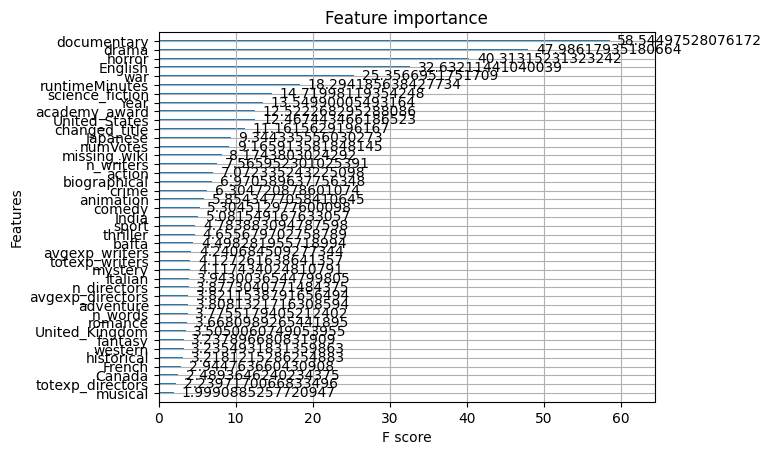

In [445]:
##
# XGBoost - experience - wiki data: 74.6%
# XGBoost - wiki data: 77.5%
# XGBoost + Genre: 81%
# XGBoost + Genre + country/language: 84% (submission server 85.8%)
# XGBoost + Genre + country/language + budget: 83.8%
# XGBoost + budget: 79.9%
##

from xgboost import plot_importance
import matplotlib.pyplot as plt

feature_names = X_train.drop(columns=['tconst']).columns
model = best_models['XGBoost'].named_steps['classifier']
model.get_booster().feature_names = feature_names.tolist()

# Plot feature importance
plot_importance(model, importance_type='gain')
plt.show()


In [446]:
# Load hidden validation and test sets and run through best performing prediction model

def load_valid_test(csv_file):
    
    csv_data = con.execute(f'''
        SELECT
            tconst,
            
            -- Clean up the movie title text. Remove excess whitespace, convert to lowercase, convert non-ascii to ascii equivalent, 
            -- remove everything that is non-alpanumeric or a space.
            REGEXP_REPLACE(TRANSLATE(LOWER(TRIM(primaryTitle)), 'áàãäåæßçéèêíîïñòóôöøớúûüý','aaaaaabceeeiiinoooooouuuy'),'[^a-zA-Z0-9 ]','','g') AS pTitle,
            REGEXP_REPLACE(TRANSLATE(LOWER(TRIM(originalTitle)),'áàãäåæßçéèêíîïñòóôöøớúûüý','aaaaaabceeeiiinoooooouuuy'),'[^a-zA-Z0-9 ]','','g') AS oTitle,
            
            -- Flag for indicating changed_title
            CASE
                WHEN pTitle == oTitle OR oTitle is NULL THEN 0
                ELSE 1
            END AS changed_title,
            
            -- Count number of words in title
            LENGTH(pTitle) - LENGTH(REPLACE(pTitle, ' ', '')) + 1 AS n_words,
            
            -- Merge start year and end year into single column
            CASE
                WHEN startYear LIKE '%N%' THEN endYear
                ELSE startYear
            END AS Year,
            runtimeMinutes,
            numVotes,
        FROM '{csv_file}'
    ''').df().replace('\\N',np.nan)


    combined_data = con.execute('''
        SELECT 
            td.tconst, 
            td.Year,
            COALESCE(td.runtimeMinutes,wiki.Runtime_minutes) AS runtimeMinutes,
            td.changed_title, 
            td.n_words,
            td.numVotes,
            
            e.n_writers,
            e.avgexp_writers,
            e.totexp_writers,
            e.n_directors,
            e.avgexp_directors,
            e.totexp_directors,
            
            wiki.*,
            
            -- Flag for missing wiki data
            CASE
                WHEN wiki.tconst IS NULL THEN 1
                ELSE 0
            END AS missing_wiki,
        
        FROM csv_data td
        LEFT JOIN agg_experience e ON e.tconst == td.tconst
        LEFT JOIN wiki_data_cleaned_ohe wiki ON wiki.tconst == td.tconst
        ORDER BY td.tconst
    ''').df()

    return combined_data

hidden_validation_data = load_valid_test('big-data-course-2024-projects/imdb/validation_hidden.csv')
hidden_test_data = load_valid_test('big-data-course-2024-projects/imdb/test_hidden.csv')


In [447]:
# Choose best performing model

valid_pred = best_models['XGBoost'].predict(hidden_validation_data.drop(columns=['tconst','tconst_1']))
test_pred = best_models['XGBoost'].predict(hidden_test_data.drop(columns=['tconst','tconst_1']))

print (valid_pred.mean(), test_pred.mean())

# Add predicted column
hidden_validation_data['pred_label'] = valid_pred
hidden_test_data['pred_label'] = test_pred

# Save to test file for prediction upload
#np.savetxt('valid_predictions_wiki4.txt', np.where(valid_pred == 1, 'True', 'False'), fmt='%s', newline='\n')
#np.savetxt('test_predictions_wiki4.txt', np.where(test_pred == 1, 'True', 'False'), fmt='%s', newline='\n')

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Runtime_minutes


In [ ]:
# Validate that the labels match up with the correct movie title (in case order has been messed around)

df_valid = pd.read_csv('big-data-course-2024-projects/imdb/validation_hidden.csv')
df_test = pd.read_csv('big-data-course-2024-projects/imdb/test_hidden.csv')

print ((df_valid['tconst'] == hidden_validation_data['tconst']).all(),
       (df_test['tconst'] == hidden_test_data['tconst']).all())

True True


In [ ]:
wiki_data

,tconst,pTitle,Year,runtimeMinutes,numVotes,wiki_key,categories,infobox
0,tt0003740,cabiria,1914,148,3452.0,Cabiria,"[""Category:1910s Italian-language films"", ""Cat...","{""Directed by"": ""Giovanni Pastrone"", ""Screenpl..."
1,tt0008663,a man there was,1917,65,1882.0,A_Man_There_Was,"[""Category:1917 drama films"", ""Category:1917 f...","{""Directed by"": ""Victor Sj\u00f6str\u00f6m"", ""..."
2,tt0009369,mickey,1918,93,1119.0,Mickey_(1918_film),"[""Category:1910s American films"", ""Category:19...","{""Directed by"": ""F. Richard JonesJames Young"",..."
3,tt0010307,jaccuse,1919,166,1692.0,J'Accuse...!,NaN,None
4,tt0010600,the doll,1919,66,1898.0,The_Doll_(1919_film),"[""Category:1910s German film stubs"", ""Category...","{""Directed by"": ""Ernst Lubitsch"", ""Written by""..."
...,...,...,...,...,...,...,...,...
9905,tt9850344,night shift,2020,98,1325.0,Night_Shift_(2020_film),"[""Category:2020 drama films"", ""Category:2020 f...","{""French"": ""Police"", ""Directed by"": ""Anne Font..."
9906,tt9850386,the bee gees how can you mend a broken heart,2020,111,4144.0,How_Can_You_Mend_a_Broken_Heart,NaN,None
9907,tt9900782,kaithi,2019,145,NaN,Kaithi_(2019_film),"[""Category:2010s Indian films"", ""Category:2010...","{""Directed by"": ""Lokesh Kanagaraj"", ""Written b..."
9908,tt9904802,enemy lines,2020,92,NaN,Enemy_Mine_(film),"[""Category:1980s American films"", ""Category:19...","{""Directed by"": ""Wolfgang Petersen"", ""Screenpl..."


In [449]:
unclean_wiki_data = con.execute(f'''
    SELECT tconst,
        pTitle,Year,runtimeMinutes,numVotes,
        wiki_key,Categories,infobox,
        Country,
        Language,
        Release_date,
        Runtime,
        Budget,
        Box_office,
        Directed_by,
        Written_by,
        Produced_by,
        Screenplay_by,
        Starring,
        
    -- Sub-query
    FROM
    
    (SELECT tconst,
        pTitle,Year,runtimeMinutes,numVotes,
        wiki_key,infobox,
        REGEXP_REPLACE(ARRAY_TO_STRING(categories, ','),'Category:','','g') AS Categories,
        COALESCE(JSON_EXTRACT(infobox, '$.Country'),JSON_EXTRACT(infobox, '$.Countries')) AS Country,
        COALESCE(JSON_EXTRACT(infobox, '$.Language'),JSON_EXTRACT(infobox, '$.Languages')) AS Language,
        COALESCE(JSON_EXTRACT(infobox, '$.Release date'),JSON_EXTRACT(infobox, '$.Release dates')) AS Release_date,
        COALESCE(JSON_EXTRACT(infobox, '$.Running time'),JSON_EXTRACT(infobox, '$.Running times')) AS Runtime,
        JSON_EXTRACT(infobox, '$.Budget') AS Budget,
        JSON_EXTRACT(infobox, '$.Box office') AS Box_office,
        JSON_EXTRACT(infobox, '$.Directed by') AS Directed_by,
        JSON_EXTRACT(infobox, '$.Written by') AS Written_by,
        JSON_EXTRACT(infobox, '$.Produced by') AS Produced_by,
        JSON_EXTRACT(infobox, '$.Screenplay by') AS Screenplay_by,
        JSON_EXTRACT(infobox, '$.Starring') AS Starring,
        
    FROM wiki_data
    
    -- Filter out movies that do not have release dates within +/-1 year of the specified year to prevent wrong wiki data being used
    WHERE JSON_EXTRACT(infobox, '$.Release date')  LIKE '%' || CAST(CAST(Year AS INTEGER) AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release dates') LIKE '%' || CAST(CAST(Year AS INTEGER) AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release date')  LIKE '%' || CAST(CAST(Year AS INTEGER)+1  AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release dates') LIKE '%' || CAST(CAST(Year AS INTEGER)+1  AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release date')  LIKE '%' || CAST(CAST(Year AS INTEGER)-1  AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release dates') LIKE '%' || CAST(CAST(Year AS INTEGER)-1  AS TEXT) || '%'
    )
    
''').df()

unclean_wiki_data

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,tconst,pTitle,Year,runtimeMinutes,numVotes,wiki_key,Categories,infobox,Country,Language,Release_date,Runtime,Budget,Box_office,Directed_by,Written_by,Produced_by,Screenplay_by,Starring
0,tt0003740,cabiria,1914,148,3452.0,Cabiria,"""1910s Italian-language films"",""1910s historic...","{""Directed by"": ""Giovanni Pastrone"", ""Screenpl...","""Italy""","""SilentItalian Intertitles""","""18 April 1914 (1914-04-18) (Italy)""","""200 minutes (original cut)\n190 minutes (2006...","""£50,000[3]""","""₤1 million""","""Giovanni Pastrone""",None,"""Giovanni Pastrone""","""Giovanni Pastrone""","""Bartolomeo Pagano, Lidia Quaranta"""
1,tt0008663,a man there was,1917,65,1882.0,A_Man_There_Was,"""1917 drama films"",""1917 films"",""All articles ...","{""Directed by"": ""Victor Sj\u00f6str\u00f6m"", ""...","""Sweden""","""Silent film""","""29 January 1917 (1917-01-29)""","""65 minutes""","""60,000 SEK""",None,"""Victor Sjöström""","""Gustaf Molander\nVictor Sjöström""","""Charles Magnusson""",None,"""Victor Sjöström"""
2,tt0009369,mickey,1918,93,1119.0,Mickey_(1918_film),"""1910s American films"",""1910s English-language...","{""Directed by"": ""F. Richard JonesJames Young"",...","""United States""","""Silent filmEnglish intertitles""","""August 1918 (1918-08)""","""93 minutes""","""$250,000""","""$16,450,000""","""F. Richard JonesJames Young""","""J.G. Hawks""","""Mabel NormandMack Sennett""",None,"""Mabel Normand"""
3,tt0010600,the doll,1919,66,1898.0,The_Doll_(1919_film),"""1910s German film stubs"",""1910s German films""...","{""Directed by"": ""Ernst Lubitsch"", ""Written by""...","""Weimar Republic""","""Silent film""","""5 December 1919 (1919-12-05)""","""70 minutes""",None,None,"""Ernst Lubitsch""","""Hanns KrälyErnst Lubitsch""","""Paul Davidson""",None,"""Ossi OswaldaHermann ThimigVictor Janson"""
4,tt0011439,the mark of zorro,1920,79,2439.0,The_Mark_of_Zorro_(1920_film),"""1920 Western (genre) films"",""1920 films"",""192...","{""Directed by"": ""Fred Niblo"", ""Written by"": ""J...","""United States""","""Silent (English intertitles)""","""November 27, 1920 (1920-11-27)""","""90 minutes""","""$169,187.05[1]""","""over $500,000[1]""","""Fred Niblo""","""Johnston McCulley (story)\nEugene Miller (sce...","""Douglas Fairbanks""",None,"""Douglas Fairbanks\nMarguerite De La Motte\nNo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8433,tt5990444,the trap,2019,90,1519.0,Time_Trap_(film),"""2010s American films"",""2010s English-language...","{""Directed by"": ""Mark Dennis\nBen Foster"", ""Wr...","""United States""","""English""","""May 19, 2017 (2017-05-19) (Seattle Internatio...","""95 minutes""",None,None,"""Mark Dennis\nBen Foster""","""Mark Dennis""","""Mark Dennis\nBen Foster""",None,"""Brianne Howey\nCassidy Erin Gifford\nOlivia D..."
8434,tt6772946,the campus,2018,84,2434.0,Raw_(film),"""2010s French-language films"",""2010s French fi...","{""Directed by"": ""Julia Ducournau"", ""Written by...","""France\nBelgium""","""French""","""14 May 2016 (2016-05-14) (Cannes)[1]\n15 Marc...","""99 minutes[2]""","""€3.48 million[3]\n($3.8 million)""","""$3.1 million[4]""","""Julia Ducournau""","""Julia Ducournau""","""Jean de Forêts""",None,"""Garance Marillier\nElla Rumpf\nLaurent Lucas"""
8435,tt7658610,the final blade,2018,91,2143.0,Blade_Runner_2049,"""2010s American films"",""2010s mystery thriller...","{""Directed by"": ""Denis Villeneuve"", ""Screenpla...","""United States[5]""","""English""","""October 3, 2017 (2017-10-03) (Dolby Theatre)\...","""163 minutes[4]""","""$150–185 million[6][7][8]""","""$267.7 million[9]""","""Denis Villeneuve""",None,"""Andrew A. Kosove\nBroderick Johnson\nBud York...","""Hampton Fancher\nMichael Green""","""Ryan Gosling\nHarrison Ford\nAna de Armas\nSy..."
8436,tt8080556,the director and the jedi,2018,95,1037.0,Star_Wars:_The_Last_Jedi,"""2010s American films"",""2010s English-language...","{""Directed by"": ""Rian Johnson"", ""Written by"": ...","""United States"""

In [450]:
unclean_wiki_data.to_csv('wiki_data_unclean.csv')

In [451]:
wiki_data_clean = con.execute(f'''
    SELECT tconst,
        pTitle,Year,runtimeMinutes,numVotes,
        wiki_key,
        REGEXP_EXTRACT_ALL(Runtime, '[0-9]+')[1] AS Runtime_minutes,
    
    -- Extract film genres from categories
    
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%action%' THEN 1 ELSE 0 END AS action,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%adventure%' THEN 1 ELSE 0 END AS adventure,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%animation%' THEN 1 ELSE 0 END AS animation,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%biographical%' THEN 1 ELSE 0 END AS biographical,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%comedy%' THEN 1 ELSE 0 END AS comedy,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%crime%' THEN 1 ELSE 0 END AS crime,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%drama%' THEN 1 ELSE 0 END AS drama,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%documentary%' THEN 1 ELSE 0 END AS documentary,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%fantasy%' THEN 1 ELSE 0 END AS fantasy,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%historical%' THEN 1 ELSE 0 END AS historical,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%horror%' THEN 1 ELSE 0 END AS horror,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%musical%' THEN 1 ELSE 0 END AS musical,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%mystery%' THEN 1 ELSE 0 END AS mystery,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%romance%' THEN 1 ELSE 0 END AS romance,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%science fiction%' THEN 1 ELSE 0 END AS science_fiction,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%sport%' THEN 1 ELSE 0 END AS sport,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%thriller%' THEN 1 ELSE 0 END AS thriller,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%war%' THEN 1 ELSE 0 END AS war,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%western%' THEN 1 ELSE 0 END AS western,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%academy award%' THEN 1 ELSE 0 END AS academy_award,
    CASE WHEN ARRAY_TO_STRING(categories, ',') ILIKE '%bafta%' THEN 1 ELSE 0 END AS bafta,
    
    -- Extract country of film. Only major countries are selected to prevent overfitting. 
    -- English speaking are selected because most films are in English
    -- Japan and France are selected in language
    
    CASE WHEN Country ILIKE '%United States%' THEN 1 ELSE 0 END AS United_States,
    CASE WHEN Country ILIKE '%India%' THEN 1 ELSE 0 END AS India,
    CASE WHEN Country ILIKE '%United Kingdom%' THEN 1 ELSE 0 END AS United_Kingdom,
    CASE WHEN Country ILIKE '%Canada%' THEN 1 ELSE 0 END AS Canada,
    
    -- Extract Language of film
    -- I'm trying to prevent overlapping of same country/language e.g. Japan/japanese
    -- Hindi/Tamil combined in Indian films
    
    CASE WHEN Language ILIKE '%English%' THEN 1 ELSE 0 END AS English,
    CASE WHEN Language ILIKE '%French%' THEN 1 ELSE 0 END AS French,
    CASE WHEN Language ILIKE '%Japanese%' THEN 1 ELSE 0 END AS Japanese,
    CASE WHEN Language ILIKE '%Italian%' THEN 1 ELSE 0 END AS Italian,
    CASE WHEN Language ILIKE '%Spanish%' THEN 1 ELSE 0 END AS Spanish,
    
    -- Budget is removed for now because it does not help improve the score (data probably not clean enough)
    -- Extract budget and box office information
    Budget, Budget_cleaned,
    Box_office, Box_office_cleaned,
    
    CASE
        WHEN COALESCE(Budget_cleaned,0) == 0 OR COALESCE(Box_office_cleaned,0) == 0 THEN 0
        ELSE COALESCE(((Box_office_cleaned/Budget_cleaned)-1)*100,0)
    END AS profit_pc,
    
    CASE
        WHEN COALESCE(Budget_cleaned,0) == 0 OR COALESCE(Box_office_cleaned,0) == 0 THEN 1
        WHEN COALESCE(((Box_office_cleaned/Budget_cleaned)-1)*100,0) < -99 THEN 1
        WHEN COALESCE(((Box_office_cleaned/Budget_cleaned)-1)*100,0) > 100000 THEN 1
        ELSE 0
    END AS missing_finances
    
    -- Sub-query
    FROM
    (SELECT tconst,
        pTitle,Year,runtimeMinutes,numVotes,
        wiki_key,
        categories,
        REGEXP_REPLACE(ARRAY_TO_STRING(categories, ','),'Category:','','g') AS Categs,
        COALESCE(JSON_EXTRACT(infobox, '$.Country'),JSON_EXTRACT(infobox, '$.Countries')) AS Country,
        COALESCE(JSON_EXTRACT(infobox, '$.Language'),JSON_EXTRACT(infobox, '$.Languages')) AS Language,
        COALESCE(JSON_EXTRACT(infobox, '$.Release date'),JSON_EXTRACT(infobox, '$.Release dates')) AS Release_date,
        COALESCE(JSON_EXTRACT(infobox, '$.Running time'),JSON_EXTRACT(infobox, '$.Running times')) AS Runtime,
        JSON_EXTRACT(infobox, '$.Budget') AS Budget,
        JSON_EXTRACT(infobox, '$.Box office') AS Box_office,
        JSON_EXTRACT(infobox, '$.Directed by') AS Directed_by,
        JSON_EXTRACT(infobox, '$.Written by') AS Written_by,
        JSON_EXTRACT(infobox, '$.Produced by') AS Produced_by,
        JSON_EXTRACT(infobox, '$.Screenplay by') AS Screenplay_by,
        JSON_EXTRACT(infobox, '$.Starring') AS Starring,       
        
        -- Clean the budget info (partially :()
        REGEXP_REPLACE(Budget, '\\[[0-9]*\\]', '', 'g') as b1,
        REGEXP_REPLACE(b1, '–\\$?[0-9]+\\.?[0-9]*', '')  as b2,
        REGEXP_REPLACE(b2, '\\(.*\\)', '', 'g')  as b3,
        REGEXP_REPLACE(b3, '[^0-9.]', '', 'g')  as b4,
        REGEXP_REPLACE(b4, '^\\.', '')  as bc,
        
        CASE
            WHEN Budget LIKE '%million%' THEN COALESCE(TRY_CAST(bc AS DOUBLE) * 1000000, 0)
            WHEN Budget LIKE '%billion%' THEN COALESCE(TRY_CAST(bc AS DOUBLE) * 1000000000, 0)
            WHEN Budget LIKE '%crore%' THEN COALESCE(TRY_CAST(bc AS DOUBLE) * 10000000, 0)
            ELSE COALESCE(TRY_CAST(bc AS DOUBLE), 0)
        END AS Budget_cleaned,
        
        -- Clean the box office info (partially :()
        REGEXP_REPLACE(Box_office, '\\[[0-9]*\\]', '', 'g') as o1,
        REGEXP_REPLACE(o1, '–\\$?[0-9]+\\.?[0-9]*', '')  as o2,
        REGEXP_REPLACE(o2, '\\(.*\\)', '', 'g')  as o3,
        REGEXP_REPLACE(o3, '[^0-9.]', '', 'g')  as o4,
        REGEXP_REPLACE(o4, '^\\.', '')  as oc,
        
        CASE
            WHEN Box_office LIKE '%million%' THEN COALESCE(TRY_CAST(oc AS DOUBLE) * 1000000, 0)
            WHEN Box_office LIKE '%billion%' THEN COALESCE(TRY_CAST(oc AS DOUBLE) * 1000000000, 0)
            WHEN Box_office LIKE '%crore%' THEN COALESCE(TRY_CAST(oc AS DOUBLE) * 10000000, 0)
            ELSE COALESCE(TRY_CAST(oc AS DOUBLE), 0)
        END AS Box_office_cleaned,
       
    FROM wiki_data
    
    -- Filter out movies that do not have release dates within +/-1 year of the specified year to prevent wrong wiki data being used
    WHERE JSON_EXTRACT(infobox, '$.Release date')  LIKE '%' || CAST(CAST(Year AS INTEGER) AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release dates') LIKE '%' || CAST(CAST(Year AS INTEGER) AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release date')  LIKE '%' || CAST(CAST(Year AS INTEGER)+1  AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release dates') LIKE '%' || CAST(CAST(Year AS INTEGER)+1  AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release date')  LIKE '%' || CAST(CAST(Year AS INTEGER)-1  AS TEXT) || '%' OR
          JSON_EXTRACT(infobox, '$.Release dates') LIKE '%' || CAST(CAST(Year AS INTEGER)-1  AS TEXT) || '%'
    )
    
''').df()

wiki_data_clean

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,tconst,pTitle,Year,runtimeMinutes,numVotes,wiki_key,Runtime_minutes,action,adventure,animation,...,French,Japanese,Italian,Spanish,Budget,Budget_cleaned,Box_office,Box_office_cleaned,profit_pc,missing_finances
0,tt0003740,cabiria,1914,148,3452.0,Cabiria,200,0,1,0,...,0,0,1,0,"""£50,000[3]""",5.000000e+04,"""₤1 million""",1.000000e+06,1900.000000,0
1,tt0008663,a man there was,1917,65,1882.0,A_Man_There_Was,65,0,0,0,...,0,0,0,0,"""60,000 SEK""",6.000000e+04,None,0.000000e+00,0.000000,1
2,tt0009369,mickey,1918,93,1119.0,Mickey_(1918_film),93,0,0,0,...,0,0,0,0,"""$250,000""",2.500000e+05,"""$16,450,000""",1.645000e+07,6480.000000,0
3,tt0010600,the doll,1919,66,1898.0,The_Doll_(1919_film),70,0,0,0,...,0,0,0,0,None,0.000000e+00,None,0.000000e+00,0.000000,1
4,tt0011439,the mark of zorro,1920,79,2439.0,The_Mark_of_Zorro_(1920_film),90,0,1,0,...,0,0,0,0,"""$169,187.05[1]""",1.691870e+05,"""over $500,000[1]""",5.000000e+05,195.530893,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8433,tt5990444,the trap,2019,90,1519.0,Time_Trap_(film),95,1,1,0,...,0,0,0,0,None,0.000000e+00,None,0.000000e+00,0.000000,1
8434,tt6772946,the campus,2018,84,2434.0,Raw_(film),99,0,0,0,...,1,0,0,0,"""€3.48 million[3]\n($3.8 million)""",3.480000e+06,"""$3.1 million[4]""",3.100000e+06,-10.919540,0
8435,tt7658610,the final blade,2018,91,2143.0,Blade_Runner_2049,163,1,0,0,...,0,0,0,0,"""$150–185 million[6][7][8]""",1.500000e+08,"""$267.7 million[9]""",2.677000e+08,78.466667,0
8436,tt8080556,the director and the jedi,2018,95,1037.0,Star_Wars:_The_Last_Jedi,152,1,1,0,...,0,0,0,0,"""$300 million[2]""",3.000000e+08,"""$1.334 billion[3]""",1.334000e+09,344.666667,0


In [452]:
wiki_data_clean.to_csv('wiki_data_clean.csv')